# Kaggle Competition: Paris Housing Price Prediction (Post-competition notebook)

This notebook is the solution to the following Kaggle competition:
https://www.kaggle.com/competitions/playground-series-s3e6/overview

The competition consists in predicting house prices using a dataset that contains attributes of houses in Paris. Go to the competition webpage using the link above for more information.

Based on the evaluation metric of the competition (RMSE), this notebook achieves the 3rd place out of 703 participants.

##### Notebook author: Arnau Juanmarti
##### Last modified: 19th April 2023

## Table of Contents

* [0 SETTINGS](#0)
	* [0.1 General settings](#01)
	* [0.2 Import data](#02)
	* [0.3 First inspection of data](#03)
	* [0.4 Concatenating train with original dataset ](#04)
	* [0.5 Tagging variables](#05)
* [1 EXPLORATORY DATA ANALYSIS](#1)
	* [1.1 Distribution of target](#11)
	* [1.2 Distribution of features and their relationship with the target](#12)
		* [1.2.1 Continuous variables](#121)
		* [1.2.2 Numerical ordinal variables](#122)
		* [1.2.3 Categorical variables](#123)
	* [1.3 Correlations of numerical features with the target](#13)
* [2 PREPROCESSING](#2)
	* [2.1 Outliers](#21)
	* [2.2 Feature Engineering](#22)
	* [2.3 Encoding](#23)
	* [2.4 Scaling](#24)
* [3 MODELING](#3)
	* [3.1 XGBRegressor](#31)
		* [3.1.1 Feature Selection](#311)
		* [3.1.2 Training and predicting](#312)
	* [3.2 CatBoostRegressor](#32)
		* [3.2.1 Feature Selection](#321)
		* [3.2.2 Training and predicting](#322)
	* [3.3 RandomForestRegressor](#33)
		* [3.3.1 Feature Selection](#331)
		* [3.3.2 Training and predicting](#332)
	* [3.4 Stacking](#34)
* [4 SUBMISSION](#4)

# 0 SETTINGS <a class='anchor' id='0'></a>

## 0.1 General settings <a class='anchor' id='01'></a>

In [1]:
## Specify notebook settings
## This is to make output cells scrollable horizontally when output does not fit the screen.
#from IPython.display import display, HTML
#display(HTML("<style>pre { white-space: pre !important; }</style>"))

## This is to ensure imported custom modules get loaded automatically when the module is edited.
%load_ext autoreload
%autoreload 2

## Specify project directory
import os
os.chdir('C:/Users/Arnau Juanmarti/machinelearning_projects/Kaggle Competitions/Paris Housing Price Prediction')

## Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import own_functions as own ## Module with own custom functions
from own_functions import df_summary

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFECV

import optuna

import warnings
warnings.filterwarnings('ignore')

## Specify pandas display options
desired_width=320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns',50)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

## 0.2 Import data <a class='anchor' id='02'></a>

In [2]:
train = pd.read_csv('Original data/playground-series-s3e6/train.csv')
test = pd.read_csv('Original data/playground-series-s3e6/test.csv')
sample_submission = pd.read_csv('Original data/playground-series-s3e6/sample_submission.csv')
original = pd.read_csv('Original data/archive/ParisHousing.csv')

## 0.3 First inspection of data <a class='anchor' id='03'></a>

In [3]:
df_summary(train)

Number of rows: 22730


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,22730,0,0.0,"[0, 1, 2, 3, 4]"
squareMeters,int64,7319,0,0.0,"[34291, 95145, 92661, 97184, 61752]"
numberOfRooms,int64,100,0,0.0,"[24, 60, 45, 99, 100]"
hasYard,int64,2,0,0.0,"[1, 0, 1, 0, 0]"
hasPool,int64,2,0,0.0,"[0, 1, 1, 0, 0]"
floors,int64,101,0,0.0,"[47, 60, 62, 59, 57]"
cityCode,int64,7810,0,0.0,"[35693, 34773, 45457, 15113, 64245]"
cityPartRange,int64,10,0,0.0,"[2, 1, 4, 1, 8]"
numPrevOwners,int64,10,0,0.0,"[1, 4, 8, 1, 4]"
made,int64,33,0,0.0,"[2000, 2000, 2020, 2000, 2018]"


In [4]:
df_summary(original)

Number of rows: 10000


,Type,N Unique Values,N Missings,% Missings,Values
squareMeters,int64,9483,0,0.0,"[75523, 80771, 55712, 32316, 70429]"
numberOfRooms,int64,100,0,0.0,"[3, 39, 58, 47, 19]"
hasYard,int64,2,0,0.0,"[0, 1, 0, 0, 1]"
hasPool,int64,2,0,0.0,"[1, 1, 1, 0, 1]"
floors,int64,100,0,0.0,"[63, 98, 19, 6, 90]"
cityCode,int64,9509,0,0.0,"[9373, 39381, 34457, 27939, 38045]"
cityPartRange,int64,10,0,0.0,"[3, 8, 6, 10, 3]"
numPrevOwners,int64,10,0,0.0,"[8, 6, 8, 4, 7]"
made,int64,32,0,0.0,"[2005, 2015, 2021, 2012, 1990]"
isNewBuilt,int64,2,0,0.0,"[0, 1, 0, 0, 1]"


In [5]:
df_summary(test)

Number of rows: 15154


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,15154,0,0.0,"[22730, 22731, 22732, 22733, 22734]"
squareMeters,int64,6433,0,0.0,"[47580, 62083, 90499, 16354, 67510]"
numberOfRooms,int64,100,0,0.0,"[89, 38, 75, 47, 8]"
hasYard,int64,2,0,0.0,"[0, 0, 1, 1, 0]"
hasPool,int64,2,0,0.0,"[1, 0, 1, 1, 0]"
floors,int64,100,0,0.0,"[8, 87, 37, 9, 55]"
cityCode,int64,6632,0,0.0,"[54830, 8576, 62454, 9262, 24112]"
cityPartRange,int64,10,0,0.0,"[5, 10, 9, 6, 3]"
numPrevOwners,int64,10,0,0.0,"[3, 3, 6, 5, 7]"
made,int64,32,0,0.0,"[1995, 1994, 1997, 2019, 2014]"


In [6]:
sample_submission.head()

,id,price
0,22730,4634456.897
1,22731,4634456.897
2,22732,4634456.897
3,22733,4634456.897
4,22734,4634456.897


## 0.4 Concatenating train with original dataset  <a class='anchor' id='04'></a>
The training dataset for this competition is generated from another dataset using a deep learning model. Usually, concatenating the training dataset with the original dataset improves performance. Here I concatenate the training set with the original dataset to generate a new training set.

In [7]:
train.drop('id', axis=1, inplace=True)
train = pd.concat([train, original]).reset_index(drop=True)
train.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


## 0.5 Tagging variables <a class='anchor' id='05'></a>

In [8]:
target = 'price'
features_continuous = ['squareMeters', 'basement', 'attic', 'garage']
features_ordinal = ['numberOfRooms', 'floors', 'cityPartRange', 'numPrevOwners', 'made', 'hasGuestRoom']
features_categorical = ['hasYard', 'hasPool', 'cityCode', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']
features_all = features_continuous + features_ordinal + features_categorical

# 1 EXPLORATORY DATA ANALYSIS <a class='anchor' id='1'></a>

## 1.1 Distribution of target <a class='anchor' id='11'></a>

[Text(0.5, 1.0, 'Distribution of price')]

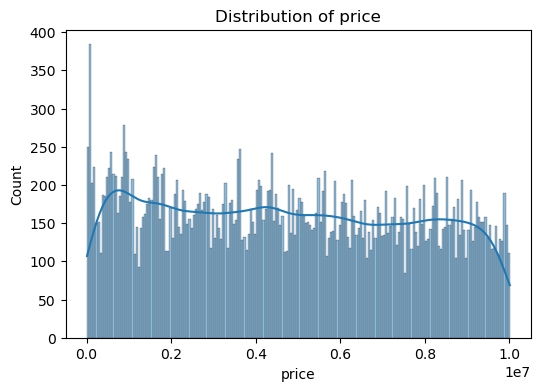

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=train, x=target, kde=True, bins=200, ax=ax)
ax.set(title='Distribution of price')

## 1.2 Distribution of features and their relationship with the target <a class='anchor' id='12'></a>
The following figures serve to have a general view of how each variable is distributed (for both the train and the test set) and what is its relationship with the target.

### 1.2.1 Continuous variables <a class='anchor' id='121'></a>

#### Distributions
The following figure shows the distribution of the continuous features for both the train and test sets

Text(0.5, 1.02, 'Distribution of continuous features')

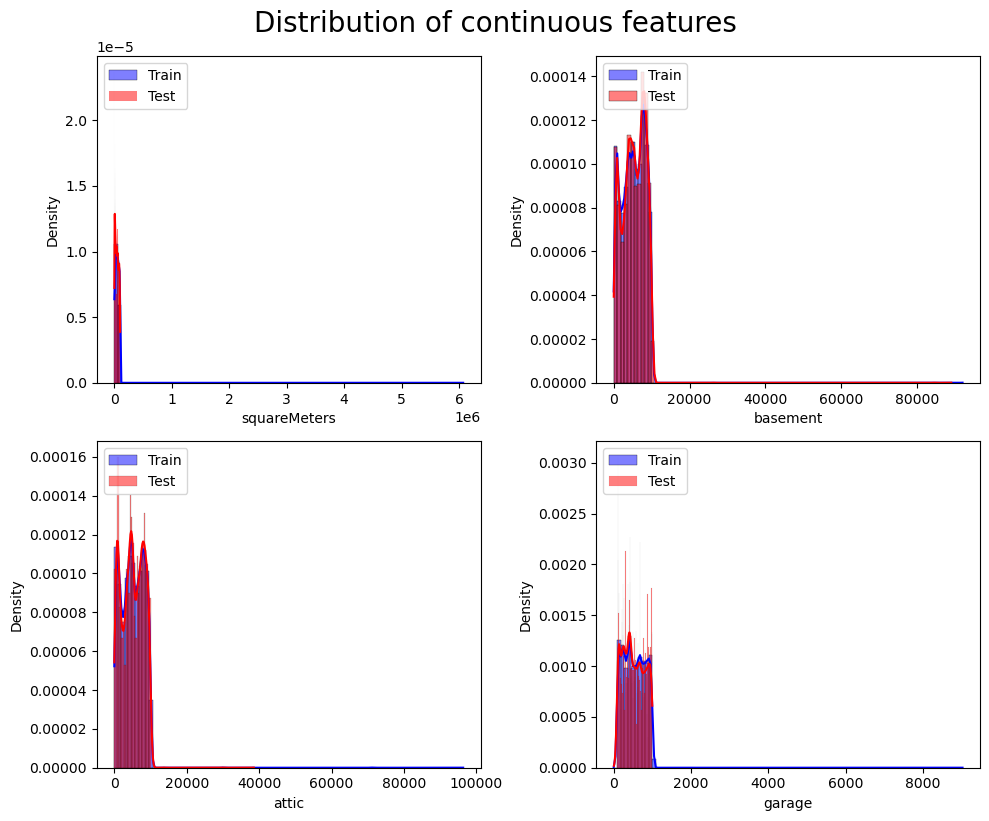

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for feature, ax in zip(features_continuous, axs.ravel()):
    sns.histplot(data=train, x=feature, bins=100, stat='density', kde=True, color='blue', label='Train', ax=ax)
    sns.histplot(data=test, x=feature, bins=100, stat='density', kde=True, color='red', label='Test', ax=ax)
    ax.legend(loc='upper left')
fig.tight_layout()
fig.suptitle('Distribution of continuous features', y=1.02, fontsize=20)

##### Takeaways:
1. For each feature, there are few extremely high values that make the distributions strongly right-skewed. These values may be outliers and we will probably have to handle them.
2. The distributions for train and test are quite similar.

#### Scatterplots
The following figure shows scatterplots of each continuous feature with the target.

Text(0.5, 1.02, 'Scatterplot of each continuous feature with the target')

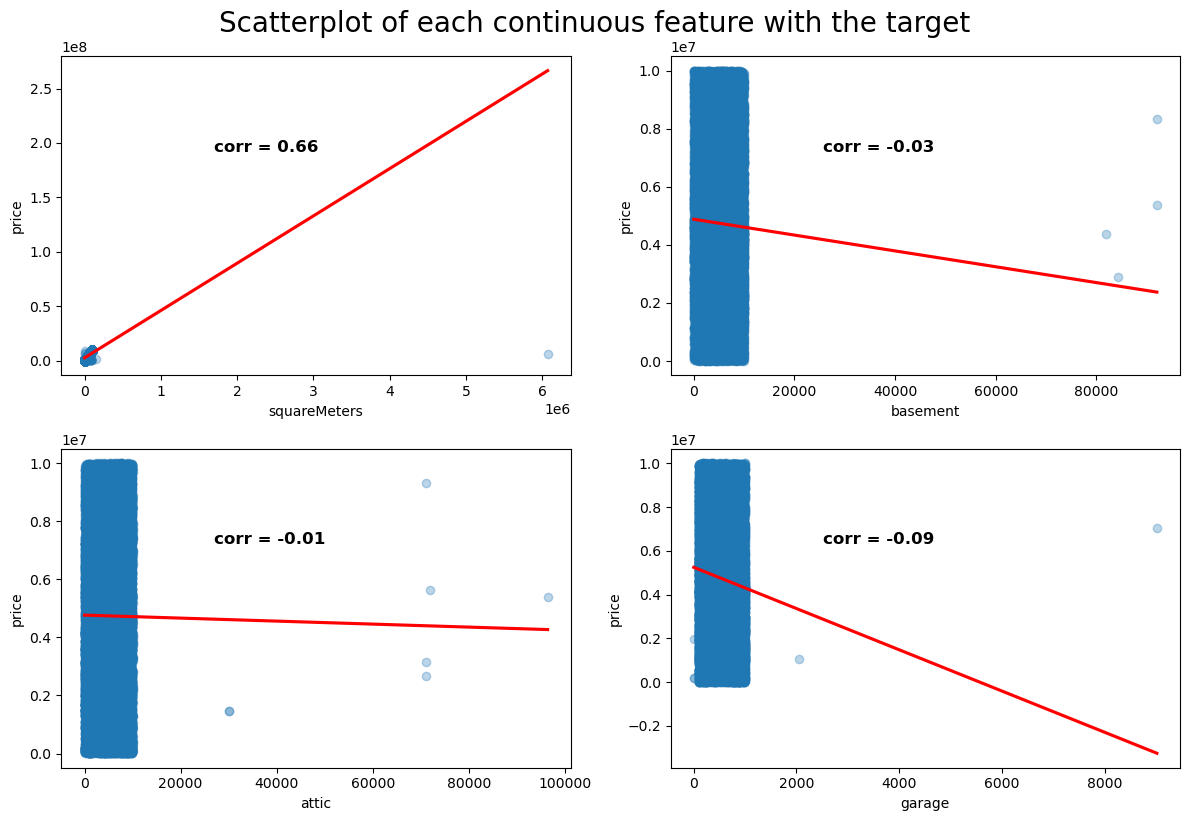

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for feature, ax in zip(features_continuous, axs.ravel()):
    sns.regplot(data=train, x=feature, y=target, ci=None, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'}, ax=ax)
    corr = train[feature].corr(train[target])
    ax.text(0.3, 0.7, f'corr = {round(corr, 2)}', color='black', fontsize=12, fontweight='bold', transform=ax.transAxes)
fig.tight_layout()
fig.suptitle('Scatterplot of each continuous feature with the target', y=1.02, fontsize=20)

##### Takeaways:
1. As noted in the figure above, there are few very high values in each feature. Outside those values, there seems to be no relationship with the continuous features and the target. An exception could be the feature squareMeters. Let's plot the same figure for this feature but excluding the unusually high value.

Text(0.3, 0.7, 'corr = 0.66')

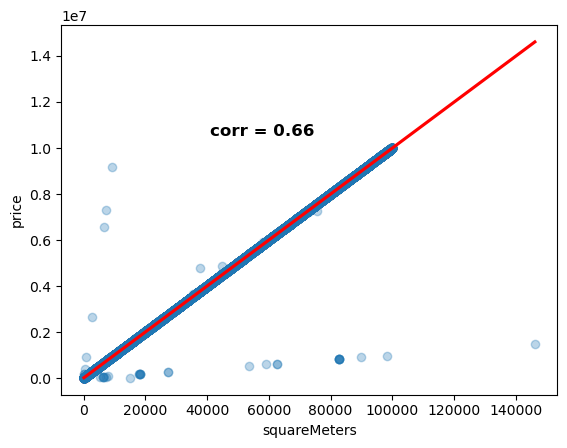

In [12]:
fig, ax = plt.subplots()
sns.regplot(data=train[train['squareMeters'] < 5000000], x='squareMeters', y=target, ci=None, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'}, ax=ax)
corr = train['squareMeters'].corr(train[target])
ax.text(0.3, 0.7, f'corr = {round(corr, 2)}', color='black', fontsize=12, fontweight='bold', transform=ax.transAxes)

##### Takeaways:
1. For the feature squareMeters, there is a clear positive linear relationship with the target.

### 1.2.2 Numerical ordinal variables <a class='anchor' id='122'></a>

#### Distribution and relationship with target
The following figure shows the distribution of each numerical ordinal feature for both the train and test sets and the mean price for each value of the feature.

Text(0.5, 1.02, 'Distribution of numerical ordinal variables and relationship with target')

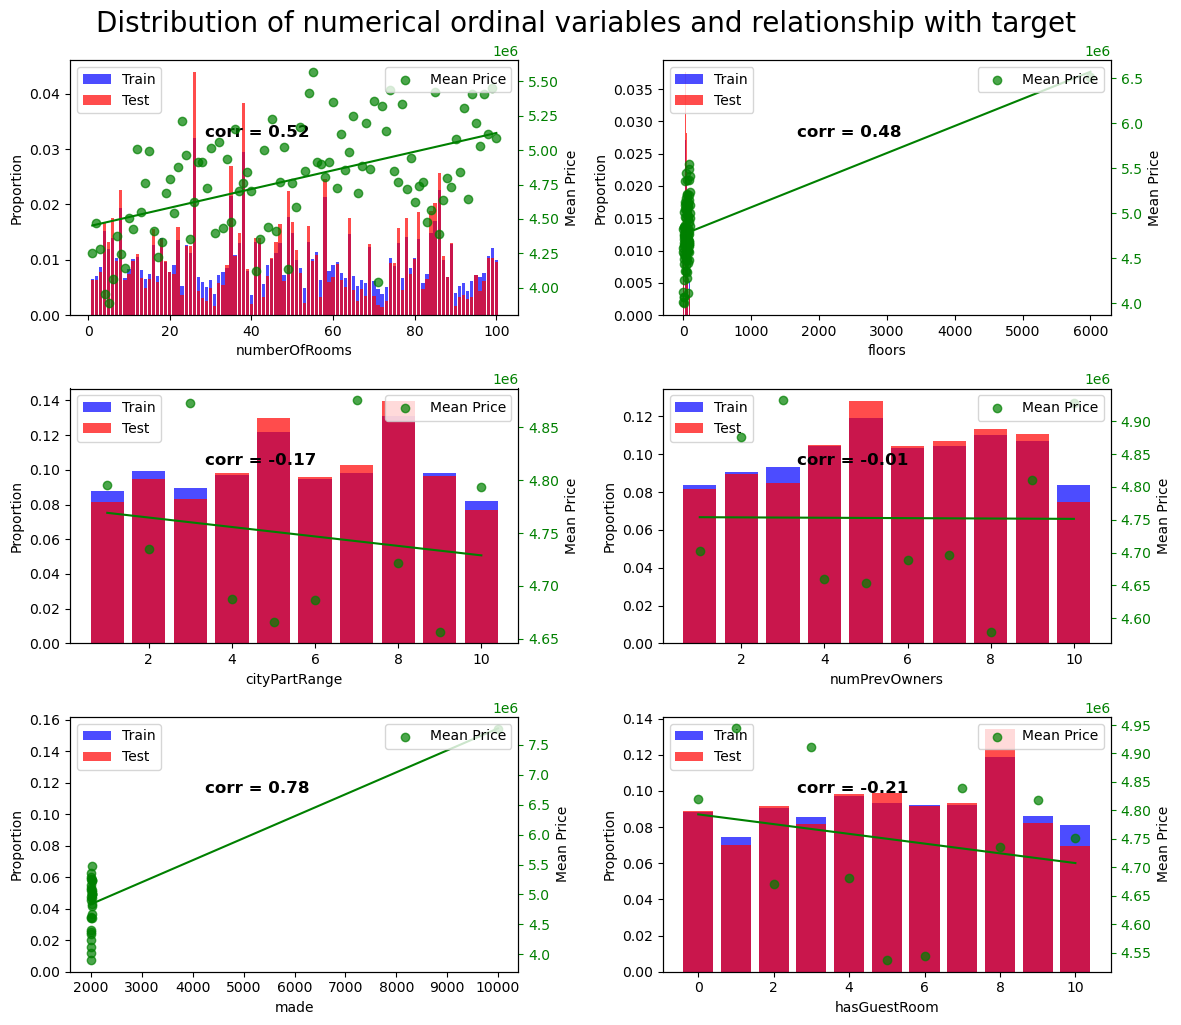

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
for feature, ax in zip(features_ordinal, axs.ravel()):
    values_count_train = train[feature].value_counts()/len(train)
    values_count_test = test[feature].value_counts()/len(test)
    ax.bar(values_count_train.index, values_count_train.values, color='blue', alpha=0.7, label='Train')
    ax.bar(values_count_test.index, values_count_test.values, color='red', alpha=0.7, label='Test')
    ax.legend(loc='upper left')
    ax.set(xlabel=feature, ylabel='Proportion')

    ax2 = ax.twinx()
    values_mean_train = train.groupby(feature)[target].mean()
    x = values_mean_train.index.values
    y = values_mean_train.values
    ax2.scatter(x, y, color='green', alpha=0.7, label='Mean Price')
    ax2.tick_params(axis='y', colors='green')
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.3, 0.7, f'corr = {round(corr, 2)}', color='black', fontsize=12, fontweight='bold', transform=ax.transAxes)
    m, b = np.polyfit(x, y, 1)
    ax2.plot(x, m * x + b, color='green')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Mean Price')
fig.tight_layout()
fig.suptitle('Distribution of numerical ordinal variables and relationship with target', y=1.02, fontsize=20)

##### Takeaways:
1. Some features (floors and made) have extreme outliers. We will plot the same figure below without those outliers.
2. For the other features, the distributions of train and test are quite similar.
3. numberOfRooms shows a high positive linear relationship with price.
4. For the other features, the relationship is less clear and the direction is the opposite of what intuition would dictate.

Text(0.5, 1.02, 'Distribution of numerical ordinal variables and relationship with target')

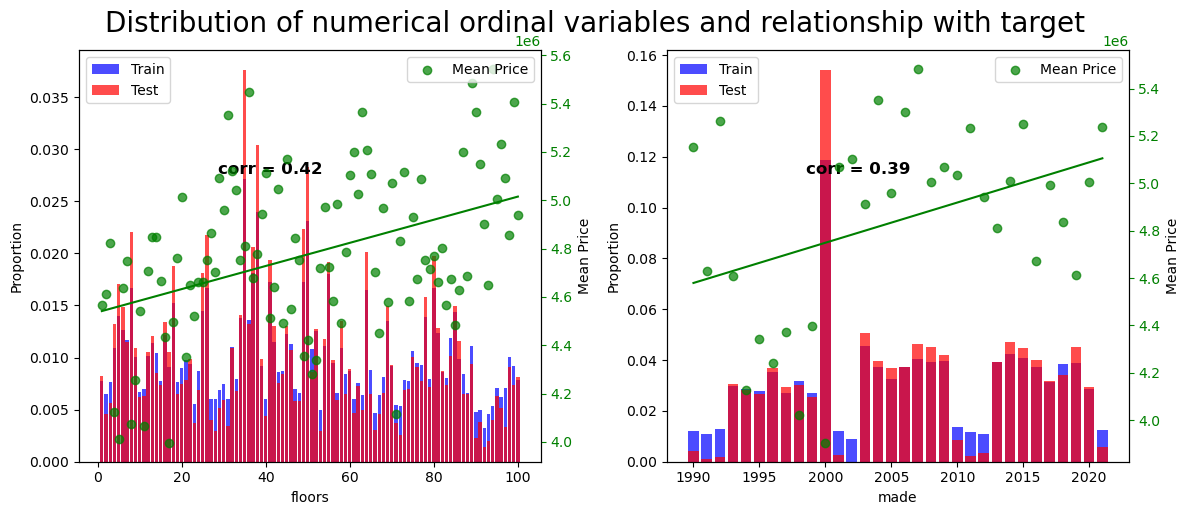

In [14]:
## Let's plot the figures for the features with those extreme outliers without the outliers.

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for feature, ax in zip(['floors', 'made'], axs.ravel()):
    train2 = train[train[feature] <= 5000]
    test2 = test[test[feature] <= 5000]
    values_count_train = train2[feature].value_counts()/len(train)
    values_count_test = test2[feature].value_counts()/len(test)
    ax.bar(values_count_train.index, values_count_train.values, color='blue', alpha=0.7, label='Train')
    ax.bar(values_count_test.index, values_count_test.values, color='red', alpha=0.7, label='Test')
    ax.legend(loc='upper left')
    ax.set(xlabel=feature, ylabel='Proportion')

    ax2 = ax.twinx()
    values_mean_train = train2.groupby(feature)[target].mean()
    x = values_mean_train.index.values
    y = values_mean_train.values
    ax2.scatter(x, y, color='green', alpha=0.7, label='Mean Price')
    ax2.tick_params(axis='y', colors='green')
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.3, 0.7, f'corr = {round(corr, 2)}', color='black', fontsize=12, fontweight='bold', transform=ax.transAxes)
    m, b = np.polyfit(x, y, 1)
    ax2.plot(x, m * x + b, color='green')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Mean Price')
fig.tight_layout()
fig.suptitle('Distribution of numerical ordinal variables and relationship with target', y=1.02, fontsize=20)

##### Takeaways:
1. The distributions of train and test sets are more or less similar.
2. Both features have a clear positive relationship with the price, and the direction is what intuition would indicate.

### 1.2.3 Categorical variables <a class='anchor' id='123'></a>

#### Distribution and relationship with target
The following figure shows the distribution of each categorical feature for both the train and test sets and the mean price for each value of the feature.

Text(0.5, 1.02, 'Distribution of categorical features and relationship with target')

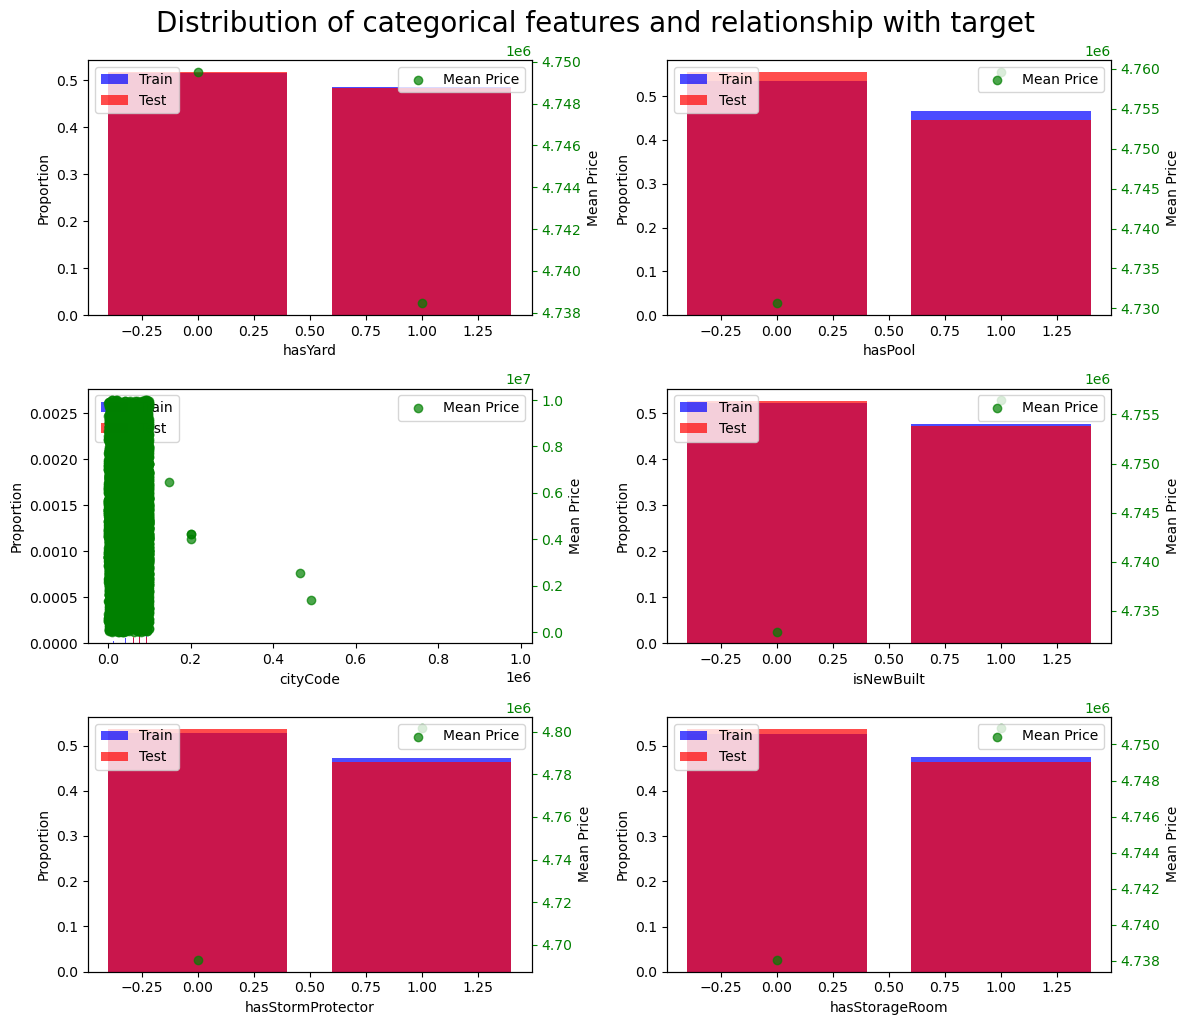

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
for feature, ax in zip(features_categorical, axs.ravel()):
    values_count_train = train[feature].value_counts()/len(train)
    values_count_test = test[feature].value_counts()/len(test)
    ax.bar(values_count_train.index, values_count_train.values, color='blue', alpha=0.7, label='Train')
    ax.bar(values_count_test.index, values_count_test.values, color='red', alpha=0.7, label='Test')
    ax.legend(loc='upper left')
    ax.set(xlabel=feature, ylabel='Proportion')

    ax2 = ax.twinx()
    values_mean_train = train.groupby(feature)[target].mean()
    x = values_mean_train.index.values
    y = values_mean_train.values
    ax2.scatter(x, y, color='green', alpha=0.7, label='Mean Price')
    ax2.tick_params(axis='y', colors='green')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Mean Price')
fig.tight_layout()
fig.suptitle('Distribution of categorical features and relationship with target', y=1.02, fontsize=20)

##### Takeaways:
1. cityCode has few very extreme values. We will plot it below without those values.
2. The feature distributions for train and test are very similar.
3. The features are related to the price and the direction of the relationship is intuitive, except for the feature hasYard.

Text(0.5, 1.02, 'Distribution of cityCode and relationship with target')

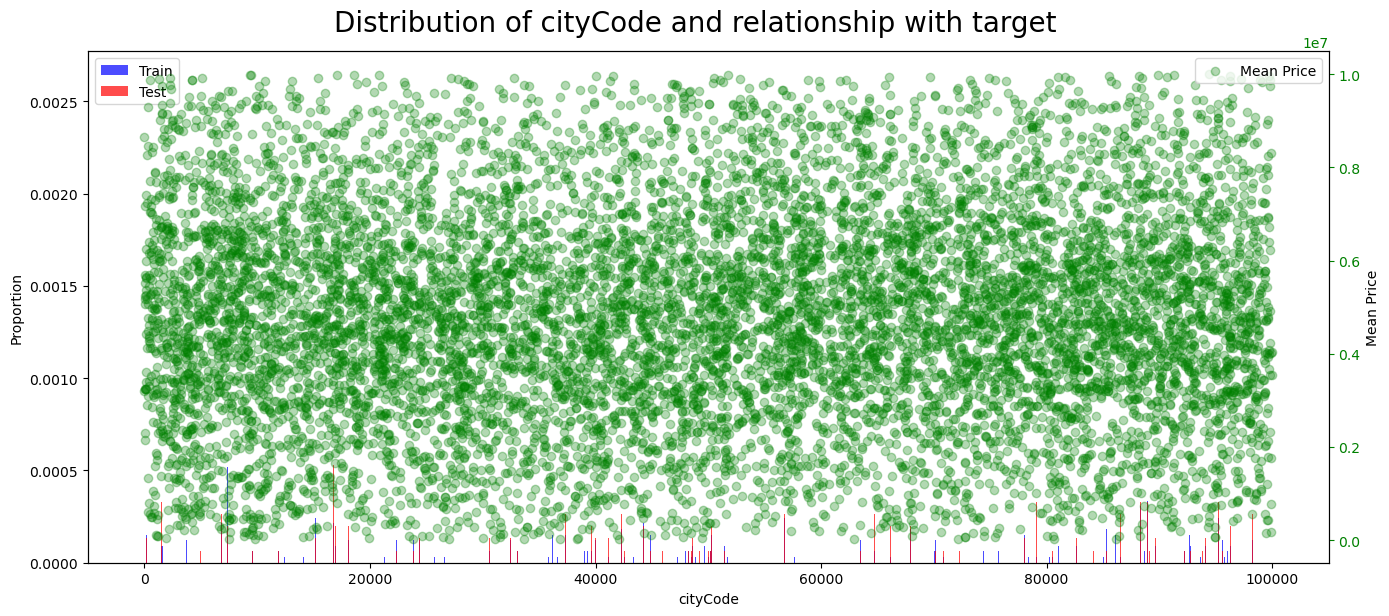

In [16]:
## Let's plot the figure for cityCode without the extreme values.

fig, ax = plt.subplots(figsize=(14, 6))
feature = 'cityCode'
train2 = train[train[feature] <= 110000]
test2 = test[test[feature] <= 110000]
values_count_train = train2[feature].value_counts()/len(train)
values_count_test = test2[feature].value_counts()/len(test)
ax.bar(values_count_train.index, values_count_train.values, color='blue', alpha=0.7, label='Train')
ax.bar(values_count_test.index, values_count_test.values, color='red', alpha=0.7, label='Test')
ax.legend(loc='upper left')
ax.set(xlabel=feature, ylabel='Proportion')

ax2 = ax.twinx()
values_mean_train = train2.groupby(feature)[target].mean()
x = values_mean_train.index.values
y = values_mean_train.values
ax2.scatter(x, y, color='green', alpha=0.3, label='Mean Price')
ax2.tick_params(axis='y', colors='green')
ax2.legend(loc='upper right')
ax2.set(ylabel='Mean Price')
fig.tight_layout()
fig.suptitle('Distribution of cityCode and relationship with target', y=1.02, fontsize=20)

##### Takeaways:
1. There are too many values (zip codes) to see a relationship with this figure. But the intuition dictates that the geographical region should be predictive of house prices. Probably aggregating the zip codes to a more meaningfull geographical region (neighborhood, for example) would show a more clear pattern.

## 1.3 Correlations of numerical features with the target <a class='anchor' id='13'></a>
The following figure shows the correlation of the numerical features with the price in order to have a first general overview of what features are most predictive of the price.

[Text(0.5, 0, 'Feature'),
 Text(0, 0.5, 'Correlation coefficient'),
 Text(0.5, 1.0, 'Correlations of numerical features with price')]

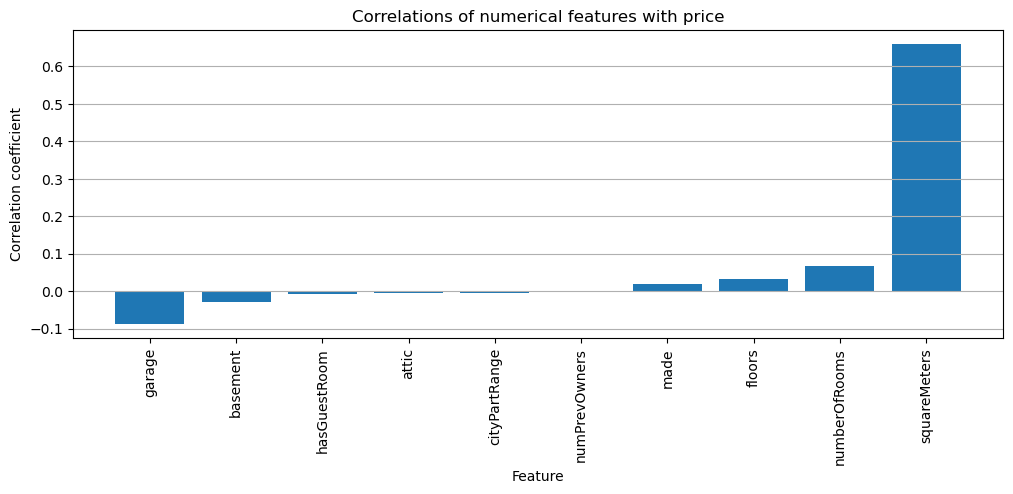

In [17]:
corr_features = features_continuous + features_ordinal
corr_series = train[corr_features + [target]].corr()[target].sort_values().drop(target)

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(corr_series.index.values, corr_series.values)
ax.set_xticklabels(corr_series.index.values, rotation=90)
ax.grid(axis='y')
ax.set(xlabel='Feature', ylabel='Correlation coefficient', title='Correlations of numerical features with price')

##### Takeaways:
1. The square meters of the house is the feature with the biggest influence in the price, with a large difference with respect to the ohter features.
2. The features 'garage' (size of the garage) and basement (size of the basement) have a negative relationship with the price, which is counterintuitive. Possibly this is explained by the fact that houses with larger garages or basements have worse other characteristics that have a positive relationship with the price.

# 2 PREPROCESSING <a class='anchor' id='2'></a>

## 2.1 Outliers <a class='anchor' id='21'></a>

In [18]:
## The following function identifies outliers using the IQR method.
## It takes as input the dataset, the features to look for outliers, and the subplot figure configurations.
## It returns a list with the outlier indices, a dataframe with the outliers identified in each column and a figure
## with a boxplot for each feature.

def plot_and_give_outliers(df, features, nrows, ncols, figsize=(12, 15)):

    #df_outliers_info = pd.DataFrame(columns=['Feature', 'Num outliers'])
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 15))

    df_outliers_idxs = []

    for i, (feature, ax) in enumerate(zip(outlier_features, axs.ravel())):
        sns.boxplot(data=train, x=feature, ax=ax)

        Q3 = np.quantile(train[feature], 0.75)
        Q1 = np.quantile(train[feature], 0.25)
        IQR = Q3 - Q1
        lower_range = Q1 - 1.5 * IQR
        upper_range = Q3 + 1.5 * IQR

        col_outlier_idxs = train[(train[feature] < lower_range) | (train[feature] > upper_range)].index.values.tolist()
        num_outliers = len(col_outlier_idxs)

        df_outliers_idxs += col_outlier_idxs

        ax.text(0.4, 0.7, f'Num outliers: {num_outliers}', color='black', fontsize=12, fontweight='bold', transform=ax.transAxes)
        
        if i==0:
            df_outliers_info = pd.DataFrame({'Feature': feature, 'Num outliers': num_outliers}, index=[i])
        else:
            df_outliers_info = pd.concat([df_outliers_info, pd.DataFrame({'Feature': feature, 'Num outliers': num_outliers}, index=[i])])
            
    fig.tight_layout()
    fig.suptitle('Boxplot of each feature', y=1.02, fontsize=20)

    df_outliers_idxs = list(set(df_outliers_idxs))
    total_outliers = len(df_outliers_idxs)
    
    print('Shape of dataset:', df.shape)
    print(f'Number of outliers found: {total_outliers}')
    print(df_outliers_info)
    
    return df_outliers_idxs

Shape of dataset: (32730, 17)
Number of outliers found: 20
         Feature  Num outliers
0   squareMeters             1
1       basement             4
2          attic             7
3         garage             2
4  numberOfRooms             0
5         floors             1
6  cityPartRange             0
7  numPrevOwners             0
8           made             5
9   hasGuestRoom             0


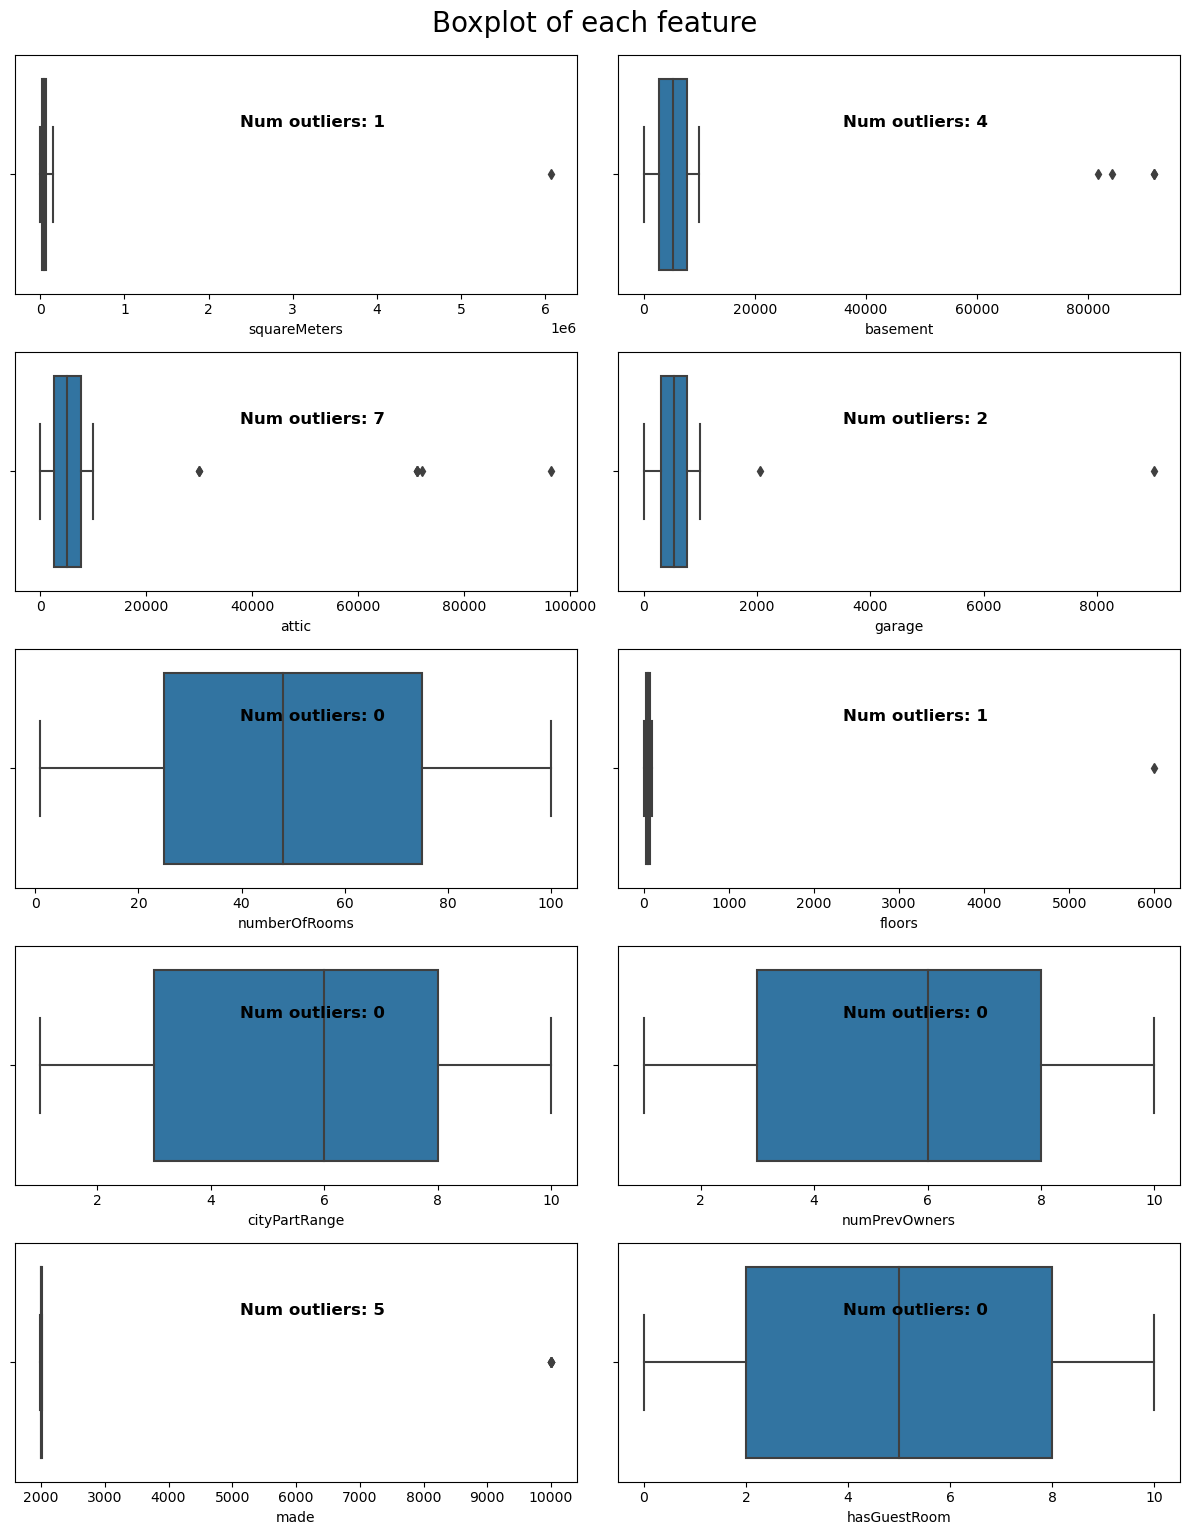

In [19]:
## Explore and identify outliers in the train set and return a list of outlier indices.
outlier_features = features_continuous + features_ordinal
train_outliers_idxs = plot_and_give_outliers(train, outlier_features, nrows=5, ncols=2)

In [20]:
## Remove outliers from the train set.
train = train.drop(train_outliers_idxs, axis=0).reset_index(drop=True)

## 2.2 Feature Engineering <a class='anchor' id='22'></a>
I've tried generating new features but they do not improve performance so they are not used. I leave the code here for reference.

In [21]:
'''
for df in [train, test]:
    ## Number of luxuries
    df['num_luxuries'] = df[['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']].sum(axis=1)
    
    ## Indicator for houses that are big in terms of several attributes
    df['big_house'] = np.where((df['squareMeters'] > df['squareMeters'].quantile(q=0.6)) &\
                              (df['numberOfRooms'] > df['numberOfRooms'].quantile(q=0.6)) &\
                               (df['floors'] > df['floors'].quantile(q=0.6)) &\
                                (df['basement'] > df['basement'].quantile(q=0.6)) &\
                              (df['attic'] > df['attic'].quantile(q=0.6)) &\
                              (df['garage'] > df['garage'].quantile(q=0.6)) &\
                              (df['hasGuestRoom'] > df['hasGuestRoom'].quantile(q=0.6)), 1, 0)

features_new = ['num_luxuries', 'big_house']
features_all += features_new
features_all
'''

"\nfor df in [train, test]:\n    ## Number of luxuries\n    df['num_luxuries'] = df[['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']].sum(axis=1)\n    \n    ## Indicator for houses that are big in terms of several attributes\n    df['big_house'] = np.where((df['squareMeters'] > df['squareMeters'].quantile(q=0.6)) &                              (df['numberOfRooms'] > df['numberOfRooms'].quantile(q=0.6)) &                               (df['floors'] > df['floors'].quantile(q=0.6)) &                                (df['basement'] > df['basement'].quantile(q=0.6)) &                              (df['attic'] > df['attic'].quantile(q=0.6)) &                              (df['garage'] > df['garage'].quantile(q=0.6)) &                              (df['hasGuestRoom'] > df['hasGuestRoom'].quantile(q=0.6)), 1, 0)\n\nfeatures_new = ['num_luxuries', 'big_house']\nfeatures_all += features_new\nfeatures_all\n"

## 2.3 Encoding <a class='anchor' id='23'></a>

## 2.4 Scaling <a class='anchor' id='24'></a>

In [22]:
scale_features = [feature for feature in features_all if feature!='cityCode']

sc = StandardScaler()
train[scale_features] = sc.fit_transform(train[scale_features])
test[scale_features] = sc.transform(test[scale_features])

# 3 MODELING <a class='anchor' id='3'></a>

##### Function to train and predict
The following function performs cross-validation and returns the out-of-fold validation and test predictions.

In [23]:
def train_and_predict(model, train, test, features, target, n_splits, fit_params={}, evaluation=True):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=100)

    preds_val = np.zeros(train.shape[0])
    preds_test = np.zeros(test.shape[0])

    folds_score = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = model
        if evaluation==True:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **fit_params)
        else:
            model.fit(X_train, y_train, **fit_params)

        pred_val = model.predict(X_val)
        preds_val[val_idx] = pred_val

        pred_test = model.predict(test[features])
        preds_test += pred_test / 5

        fold_score = np.sqrt(mean_squared_error(y_val, pred_val))
        folds_score.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(folds_score)}')
    print(f'MEAN OOF SCORE: {np.sqrt(mean_squared_error(train[target], preds_val))}')
    
    return preds_val, preds_test

##### Function to perform Recursive Feature Elimination (RFECV)
This function performs recursive feature elimination and returns a dataframe with the features ranked, a list of the selected features, a list of the not selected features and the best CV score. It also shows a figure with the CV results.

In [24]:
def rfecv_custom(estimator, cv, scoring, X, y, name):
    rfecv = RFECV(estimator=estimator, cv=cv, scoring=scoring, verbose=0)
    rfecv.fit(X, y)

    cv_results_df = pd.DataFrame(rfecv.cv_results_)
    n_features_selected = rfecv.n_features_
    features_selected_bool = rfecv.support_.tolist()
    features_selected_ranking = rfecv.ranking_.tolist()
    best_cv_score = cv_results_df['mean_test_score'].sort_values(ascending=False).reset_index(drop=True)[0]

    rfe_df = pd.DataFrame(columns=['Feature', 'Selected', 'Ranking'])
    rfe_df['Feature'] = X.columns
    rfe_df['Selected'] = features_selected_bool
    rfe_df['Ranking'] = features_selected_ranking
    selected_features = rfe_df[rfe_df['Selected'] == True]['Feature'].tolist()
    notselected_features = rfe_df[rfe_df['Selected'] == False]['Feature'].tolist()
    rfe_df.sort_values(by='Ranking', ascending=True, inplace=True)
    rfe_df.reset_index(drop=True, inplace=True)

    print(rfe_df)
    print(' ')
    print('Optimal number of features: ' + str(n_features_selected) + ' (from ' + str(X.shape[1]) + ')')
    print(' ')
    print('CV Score: ' + str(best_cv_score))
    print(' ')
    print('Features selected: ')
    print(selected_features)
    print(' ')
    print('Features not selected: ')
    print(notselected_features)

    plt.figure(figsize=(10, 6))
    plt.suptitle('Cross-validation mean score for RFE', fontsize=18)
    plt.title(
        'Best CV score: ' + str(round(best_cv_score, 4)) + '\n' + 'N features selected: ' + str(n_features_selected),
        fontsize=10)
    plt.xlabel('Number of features selected')
    plt.ylabel('CV Score')
    plt.plot(range(1, cv_results_df.shape[0] + 1), cv_results_df['mean_test_score'])
    plt.xticks(ticks=range(1, cv_results_df.shape[0] + 1), labels=range(1, cv_results_df.shape[0] + 1))
    plt.axvline(x=n_features_selected, linestyle='dashed', color='k')
    #plt.show()
    plt.savefig('Figures/rfecv_' + name + '.pdf')

    return rfe_df, selected_features, notselected_features, best_cv_score

##### Datasets to save validation and prediction arrays of each model

In [25]:
preds_val_df = pd.DataFrame()
preds_test_df = pd.DataFrame()

## 3.1 XGBRegressor <a class='anchor' id='31'></a>

### 3.1.1 Feature Selection <a class='anchor' id='311'></a>
Applying the RFECV method of feature selection to the XGB model does not improve performance. Therefore, I keep the original features.

In [26]:
'''
model = XGBRegressor(random_state=100, objective='reg:squarederror')
features = features_all
kf = KFold(n_splits=5, shuffle=True, random_state=100)
rfe_df, selected_features_xgb, notselected_features_xgb, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'xgb')

with open('Tables/selected_features_xgb.pickle', 'wb') as handle:
    pickle.dump(selected_features_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('Tables/selected_features_xgb.pickle', 'rb') as handle:
    selected_features_xgb = pickle.load(handle)
'''

"\nmodel = XGBRegressor(random_state=100, objective='reg:squarederror')\nfeatures = features_all\nkf = KFold(n_splits=5, shuffle=True, random_state=100)\nrfe_df, selected_features_xgb, notselected_features_xgb, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'xgb')\n\nwith open('Tables/selected_features_xgb.pickle', 'wb') as handle:\n    pickle.dump(selected_features_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n\nwith open('Tables/selected_features_xgb.pickle', 'rb') as handle:\n    selected_features_xgb = pickle.load(handle)\n"

### 3.1.2 Training and predicting <a class='anchor' id='312'></a>

In [27]:
model = XGBRegressor(random_state=100, objective='reg:squarederror')
features = features_all
fit_params = {'verbose': 20}

preds_val_df['xgb'], preds_test_df['xgb'] = train_and_predict(model, train, test, features, target, n_splits=5, fit_params=fit_params, evaluation=True)

[0]	validation_0-rmse:3915232.75346
[20]	validation_0-rmse:149497.60588
[40]	validation_0-rmse:149928.24003
[60]	validation_0-rmse:150983.65309
[80]	validation_0-rmse:150049.11073
[99]	validation_0-rmse:149546.55503
FOLD 0 SCORE: 149546.5526602453
[0]	validation_0-rmse:3880799.44690
[20]	validation_0-rmse:116432.77319
[40]	validation_0-rmse:117032.25193
[60]	validation_0-rmse:116927.83225
[80]	validation_0-rmse:116969.41804
[99]	validation_0-rmse:117740.01511
FOLD 1 SCORE: 117740.01453259819
[0]	validation_0-rmse:3892347.14700
[20]	validation_0-rmse:195191.07757
[40]	validation_0-rmse:194996.27676
[60]	validation_0-rmse:195289.46130
[80]	validation_0-rmse:195234.04302
[99]	validation_0-rmse:195180.44474
FOLD 2 SCORE: 195180.44235871025
[0]	validation_0-rmse:3951675.12611
[20]	validation_0-rmse:102429.29604
[40]	validation_0-rmse:102679.78570
[60]	validation_0-rmse:107395.46640
[80]	validation_0-rmse:107420.17649
[99]	validation_0-rmse:108193.26866
FOLD 3 SCORE: 108193.2717423097
[0]	va

## 3.2 CatBoostRegressor <a class='anchor' id='32'></a>

### 3.2.1 Feature Selection <a class='anchor' id='321'></a>
Applying the RFECV method of feature selection to the CatBoost model does not improve performance. Therefore, I keep the original features.

In [28]:
'''
model = CatBoostRegressor(random_state=100, loss_function='RMSE', objective='RMSE', eval_metric='RMSE', verbose=20)
features = features_all
kf = KFold(n_splits=5, shuffle=True, random_state=100)
rfe_df, selected_features_cb, notselected_features_cb, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'cb')

with open('Tables/selected_features_cb.pickle', 'wb') as handle:
    pickle.dump(selected_features_cb, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('Tables/selected_features_cb.pickle', 'rb') as handle:
    selected_features_cb = pickle.load(handle)
'''

"\nmodel = CatBoostRegressor(random_state=100, loss_function='RMSE', objective='RMSE', eval_metric='RMSE', verbose=20)\nfeatures = features_all\nkf = KFold(n_splits=5, shuffle=True, random_state=100)\nrfe_df, selected_features_cb, notselected_features_cb, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'cb')\n\nwith open('Tables/selected_features_cb.pickle', 'wb') as handle:\n    pickle.dump(selected_features_cb, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n\nwith open('Tables/selected_features_cb.pickle', 'rb') as handle:\n    selected_features_cb = pickle.load(handle)\n"

### 3.2.2 Training and predicting <a class='anchor' id='322'></a>

In [29]:
model = CatBoostRegressor(random_state=100, loss_function='RMSE', objective='RMSE', eval_metric='RMSE', verbose=50)
features = features_all
preds_val_df['cb'], preds_test_df['cb'] = train_and_predict(model, train, test, features, target, n_splits=5, fit_params={}, evaluation=True)

Learning rate set to 0.085013
0:	learn: 2683455.8860210	test: 2694870.7061558	best: 2694870.7061558 (0)	total: 150ms	remaining: 2m 29s
50:	learn: 172029.0704286	test: 168566.1250363	best: 168566.1250363 (50)	total: 388ms	remaining: 7.22s
100:	learn: 135994.1228176	test: 159532.6800273	best: 158761.6368752 (86)	total: 598ms	remaining: 5.32s
150:	learn: 119932.0600739	test: 161204.2084724	best: 158761.6368752 (86)	total: 803ms	remaining: 4.51s
200:	learn: 112889.9936497	test: 162543.7380222	best: 158761.6368752 (86)	total: 1.01s	remaining: 4.02s
250:	learn: 104320.7876396	test: 164899.1148066	best: 158761.6368752 (86)	total: 1.23s	remaining: 3.66s
300:	learn: 97058.7814725	test: 165679.5087897	best: 158761.6368752 (86)	total: 1.46s	remaining: 3.39s
350:	learn: 89092.6207214	test: 166748.9193554	best: 158761.6368752 (86)	total: 1.67s	remaining: 3.08s
400:	learn: 81783.8057676	test: 167523.3457594	best: 158761.6368752 (86)	total: 1.88s	remaining: 2.81s
450:	learn: 75170.6012014	test: 16818

600:	learn: 77622.3381686	test: 75391.5718861	best: 69147.3041802 (309)	total: 2.65s	remaining: 1.76s
650:	learn: 71184.2264894	test: 82566.9170133	best: 69147.3041802 (309)	total: 2.87s	remaining: 1.54s
700:	learn: 65974.7701537	test: 86208.7804244	best: 69147.3041802 (309)	total: 3.1s	remaining: 1.32s
750:	learn: 62004.4390314	test: 87840.6614839	best: 69147.3041802 (309)	total: 3.31s	remaining: 1.1s
800:	learn: 58354.4618281	test: 91629.1619079	best: 69147.3041802 (309)	total: 3.52s	remaining: 874ms
850:	learn: 55973.4032997	test: 92459.3259082	best: 69147.3041802 (309)	total: 3.74s	remaining: 655ms
900:	learn: 53048.7820524	test: 93587.7720206	best: 69147.3041802 (309)	total: 3.94s	remaining: 433ms
950:	learn: 50141.1995122	test: 94433.5708593	best: 69147.3041802 (309)	total: 4.17s	remaining: 215ms
999:	learn: 47913.1314277	test: 94805.4480777	best: 69147.3041802 (309)	total: 4.39s	remaining: 0us

bestTest = 69147.30418
bestIteration = 309

Shrink model to first 310 iterations.
FOL

## 3.3 RandomForestRegressor <a class='anchor' id='33'></a>

### 3.3.1 Feature Selection <a class='anchor' id='331'></a>
Applying the RFECV method of feature selection to the RandomForestRegressor model does not improve performance. Therefore, I keep the original features.

In [30]:
'''
model = RandomForestRegressor(random_state=100, verbose=1)
features = features_all
kf = KFold(n_splits=5, shuffle=True, random_state=100)
rfe_df, selected_features_rf, notselected_features_rf, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'rf')

with open('Tables/selected_features_rf.pickle', 'wb') as handle:
    pickle.dump(selected_features_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('Tables/selected_features_rf.pickle', 'rb') as handle:
    selected_features_rf = pickle.load(handle)
'''

"\nmodel = RandomForestRegressor(random_state=100, verbose=1)\nfeatures = features_all\nkf = KFold(n_splits=5, shuffle=True, random_state=100)\nrfe_df, selected_features_rf, notselected_features_rf, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'rf')\n\nwith open('Tables/selected_features_rf.pickle', 'wb') as handle:\n    pickle.dump(selected_features_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n\nwith open('Tables/selected_features_rf.pickle', 'rb') as handle:\n    selected_features_rf = pickle.load(handle)\n"

### 3.3.2 Training and predicting <a class='anchor' id='332'></a>

In [31]:
model = RandomForestRegressor(random_state=100, verbose=0)
features = features_all
preds_val_df['rf'], preds_test_df['rf'] = train_and_predict(model, train, test, features, target, n_splits=5, fit_params={}, evaluation=False)

FOLD 0 SCORE: 150667.43168405112
FOLD 1 SCORE: 114747.07200155553
FOLD 2 SCORE: 201633.500009103
FOLD 3 SCORE: 99074.33467670638
FOLD 4 SCORE: 97932.56274608424
MEAN CV SCORE: 132810.98022350002
MEAN OOF SCORE: 138513.64154246115


## 3.4 Stacking <a class='anchor' id='34'></a>

In [32]:
print(preds_val_df.head())
print(preds_test_df.head())

         xgb            cb           rf
0  3439275.5  3.405269e+06  3436022.451
1  9509187.0  9.525553e+06  9518848.979
2  9279515.0  9.303758e+06  9276377.854
3  9727898.0  9.689306e+06  9725601.333
4  6188529.5  6.185116e+06  6181465.997
            xgb            cb            rf
0  4.755169e+06  4.767689e+06  4.765480e+06
1  6.206974e+06  6.219823e+06  6.216740e+06
2  9.063922e+06  9.068970e+06  9.057641e+06
3  1.632995e+06  1.645795e+06  1.644630e+06
4  6.764477e+06  6.736741e+06  6.758779e+06


In [33]:
## Construct train and test sets from level 1 models
X_stack_train = preds_val_df
y_stack_train = train[target]
X_stack_test = preds_test_df

## Train and predict using LGBMRegressor as the level 2 model
kf = KFold(n_splits=5, shuffle=True, random_state=100)

preds_val = np.zeros(X_stack_train.shape[0])
preds_test = np.zeros(X_stack_test.shape[0])

folds_score = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_stack_train, y_stack_train)):
    X_train, y_train = X_stack_train.iloc[train_idx], y_stack_train.iloc[train_idx]
    X_val, y_val = X_stack_train.iloc[val_idx], y_stack_train.iloc[val_idx]

    model = LGBMRegressor(random_state=100, objective='rmse')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', verbose=50)

    pred_val = model.predict(X_val)
    preds_val[val_idx] = pred_val

    pred_test = model.predict(X_stack_test)
    preds_test += pred_test / 5

    fold_score = np.sqrt(mean_squared_error(y_val, pred_val))
    folds_score.append(fold_score)

    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(folds_score)}')
print(f'MEAN OOF SCORE: {np.sqrt(mean_squared_error(y_stack_train, preds_val))}')

preds_val_df['stack'] = preds_val
preds_val_df['price'] = train[target]
preds_test_df['stack'] = preds_test

[50]	valid_0's rmse: 151546
[100]	valid_0's rmse: 152012
FOLD 0 SCORE: 152012.1460349865
[50]	valid_0's rmse: 110691
[100]	valid_0's rmse: 110252
FOLD 1 SCORE: 110251.78034090695
[50]	valid_0's rmse: 191784
[100]	valid_0's rmse: 192002
FOLD 2 SCORE: 192002.00995138075
[50]	valid_0's rmse: 84189.4
[100]	valid_0's rmse: 83639
FOLD 3 SCORE: 83638.96278108018
[50]	valid_0's rmse: 105484
[100]	valid_0's rmse: 103545
FOLD 4 SCORE: 103545.16403043375
MEAN CV SCORE: 128290.01262775762
MEAN OOF SCORE: 134048.49609380637


# 4 SUBMISSION <a class='anchor' id='4'></a>
Preparing the submission files. The stacking approach achieves the best score. It gives an RMSE of 214107.92595, which corresponds to the 3rd position in the Private Leadearbord of the competition (out of 703 participants).

In [34]:
submission = pd.DataFrame({'id': test['id'], 'price': preds_test_df['xgb']})
submission.to_csv('Submission files/final_xgb.csv', index=False)
## Private LB Score: 215656.46187

submission = pd.DataFrame({'id': test['id'], 'price': preds_test_df['cb']})
submission.to_csv('Submission files/final_cb.csv', index=False)
## Private LB Score: 221444.38435

submission = pd.DataFrame({'id': test['id'], 'price': preds_test_df['rf']})
submission.to_csv('Submission files/final_rf.csv', index=False)
## Private LB Score: 219380.70314

submission = pd.DataFrame({'id': test['id'], 'price': preds_test_df['stack']})
submission.to_csv('Submission files/final_stack.csv', index=False)
## Private LB Score: 214107.92595


print(sample_submission.head())
print(submission.head())

      id        price
0  22730  4634456.897
1  22731  4634456.897
2  22732  4634456.897
3  22733  4634456.897
4  22734  4634456.897
      id         price
0  22730  4.765372e+06
1  22731  6.220884e+06
2  22732  9.054890e+06
3  22733  1.638508e+06
4  22734  6.746047e+06
